# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

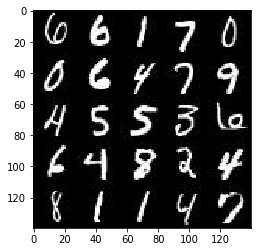

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

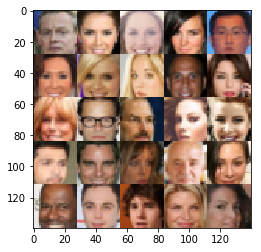

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate' )

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [37]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha=0.1
        dropout = 0.2
        
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # x1 => 14x14x64
        
        x2 = tf.layers.conv2d(x1, filters=128, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.layers.dropout(x2, dropout) 
        x2 = tf.maximum(alpha * x2, x2)
        # x2 => 7x7x128
        
        x3 = tf.layers.conv2d(x2, filters=256, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # x3 => 4x4x256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [38]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        
        alpha = 0.1
        
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(x1 * alpha, x1)
        # x1 => 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(x2 * alpha, x2)
        # x2 => 14x14x256

        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        x3 = tf.maximum(x3 * alpha, x3)
        # x3 => 28x28x128
        
        x4 = tf.layers.conv2d_transpose(x3, filters=64, kernel_size=5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4,training=is_train)
        x4 = tf.maximum(x4 * alpha, x4)
        # x4 => 28x28x64
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, 1, 'same')
        #logits => 28x28x3
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [39]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = .1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [40]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [x for x in t_vars if x.name.startswith('generator')]
    d_vars = [x for x in t_vars if x.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [41]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [42]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    batch = 0
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images *2
                # TODO: Train Model
                batch+=1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z})
                _ = sess.run(g_opt, feed_dict={input_real:batch_images, input_z:batch_z})
                
                if batch % 100 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))

                if batch % 400 == 0:
                    show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2639... Generator Loss: 1.2361
Epoch 1/2... Discriminator Loss: 1.2849... Generator Loss: 0.7669
Epoch 1/2... Discriminator Loss: 1.4642... Generator Loss: 0.7228
Epoch 1/2... Discriminator Loss: 1.4160... Generator Loss: 0.5668


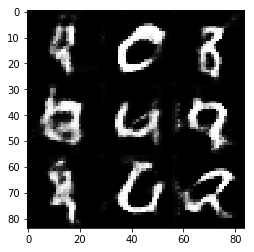

Epoch 1/2... Discriminator Loss: 1.4533... Generator Loss: 0.9755
Epoch 1/2... Discriminator Loss: 1.3605... Generator Loss: 0.6647
Epoch 1/2... Discriminator Loss: 1.1929... Generator Loss: 1.0155
Epoch 1/2... Discriminator Loss: 1.2728... Generator Loss: 0.7778


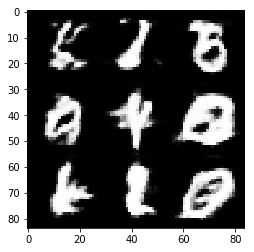

Epoch 1/2... Discriminator Loss: 1.1957... Generator Loss: 0.8650
Epoch 1/2... Discriminator Loss: 1.3156... Generator Loss: 0.6190
Epoch 1/2... Discriminator Loss: 1.0687... Generator Loss: 1.0141
Epoch 1/2... Discriminator Loss: 1.0816... Generator Loss: 1.0004


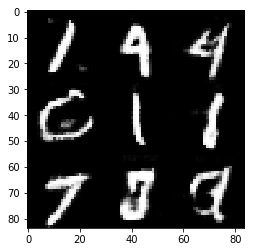

Epoch 1/2... Discriminator Loss: 1.3379... Generator Loss: 1.4128
Epoch 1/2... Discriminator Loss: 1.6217... Generator Loss: 0.3743
Epoch 1/2... Discriminator Loss: 1.1324... Generator Loss: 0.7867
Epoch 1/2... Discriminator Loss: 1.0819... Generator Loss: 1.3071


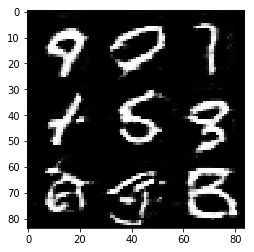

Epoch 1/2... Discriminator Loss: 1.7301... Generator Loss: 0.3433
Epoch 1/2... Discriminator Loss: 1.2060... Generator Loss: 1.4674
Epoch 2/2... Discriminator Loss: 1.0606... Generator Loss: 1.4050
Epoch 2/2... Discriminator Loss: 0.9001... Generator Loss: 1.3118


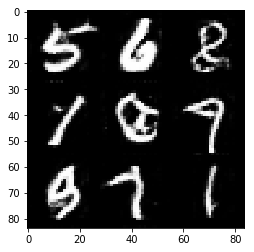

Epoch 2/2... Discriminator Loss: 1.1838... Generator Loss: 0.8415
Epoch 2/2... Discriminator Loss: 1.2080... Generator Loss: 0.6243
Epoch 2/2... Discriminator Loss: 1.5810... Generator Loss: 0.3931
Epoch 2/2... Discriminator Loss: 1.2581... Generator Loss: 0.6894


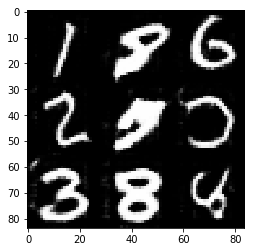

Epoch 2/2... Discriminator Loss: 0.8819... Generator Loss: 1.4413
Epoch 2/2... Discriminator Loss: 1.1132... Generator Loss: 0.9126
Epoch 2/2... Discriminator Loss: 1.1124... Generator Loss: 0.8898
Epoch 2/2... Discriminator Loss: 1.2971... Generator Loss: 0.6223


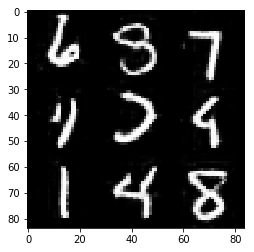

Epoch 2/2... Discriminator Loss: 0.7899... Generator Loss: 1.3947
Epoch 2/2... Discriminator Loss: 1.5213... Generator Loss: 0.4991
Epoch 2/2... Discriminator Loss: 1.0914... Generator Loss: 0.7991
Epoch 2/2... Discriminator Loss: 1.1598... Generator Loss: 0.7800


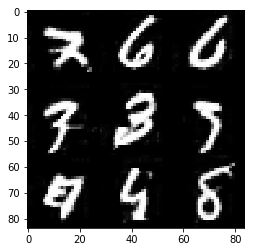

Epoch 2/2... Discriminator Loss: 0.9142... Generator Loss: 1.0020
Epoch 2/2... Discriminator Loss: 1.2122... Generator Loss: 0.7123
Epoch 2/2... Discriminator Loss: 0.8614... Generator Loss: 1.0932
Epoch 2/2... Discriminator Loss: 1.0750... Generator Loss: 0.8643


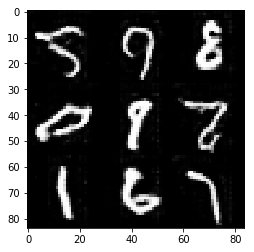

Epoch 2/2... Discriminator Loss: 1.4184... Generator Loss: 0.5287


In [43]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.4387... Generator Loss: 0.1449
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.9248


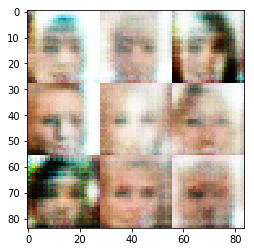

Epoch 1/1... Discriminator Loss: 1.7149... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.7255... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.9242


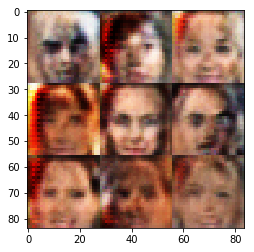

Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.8872
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.6868


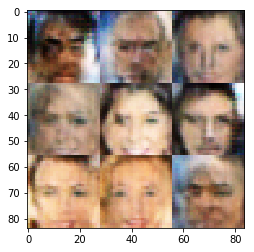

Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.7469


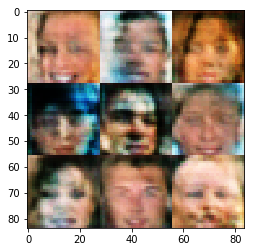

Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.5679... Generator Loss: 0.4672
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.7556


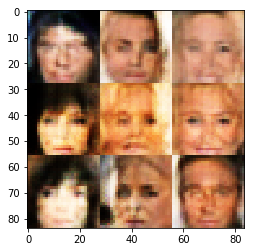

Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.5870
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.6788


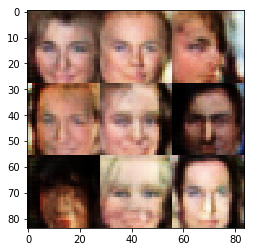

Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7117


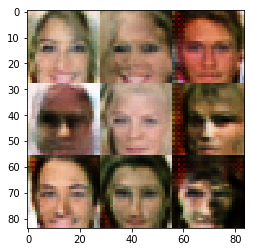

Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.8407


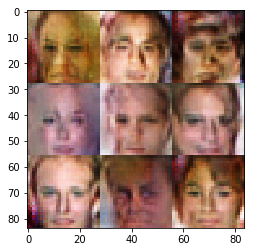

Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7488


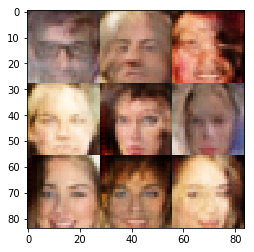

Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.7495


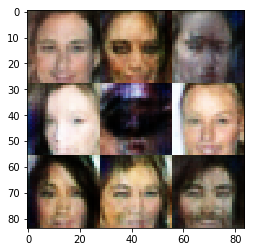

Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.7536


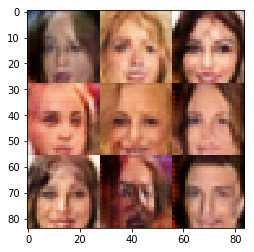

Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.9437
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.7655


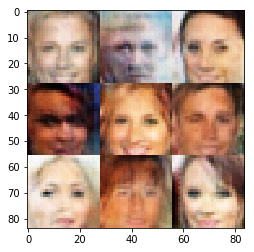

Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.5113... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.7460


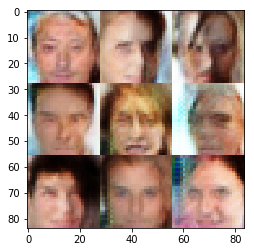

Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.9103
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7826


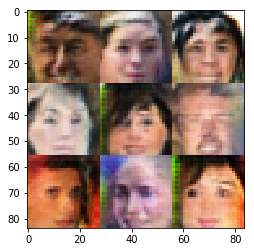

Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.8606


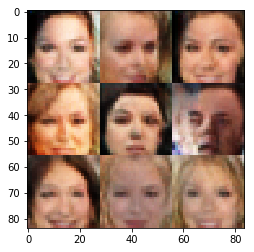

Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.8290


In [45]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 1.2104
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.5797


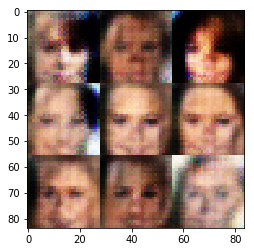

Epoch 1/1... Discriminator Loss: 1.6017... Generator Loss: 0.4802
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.9475


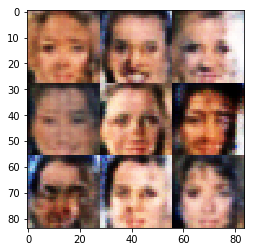

Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.5088... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.5396... Generator Loss: 1.4484
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.5713


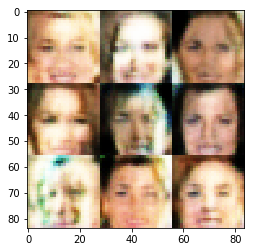

Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.5074... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.6090
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 1.1390


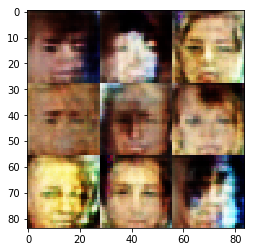

Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.7389


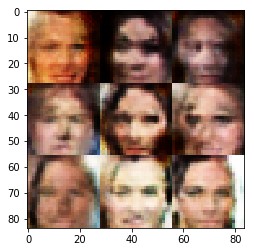

Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.2348... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.7422


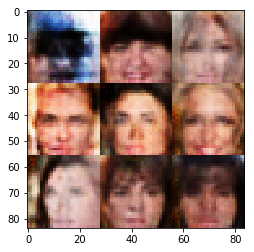

Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.7240


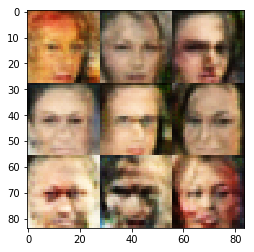

Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.9184


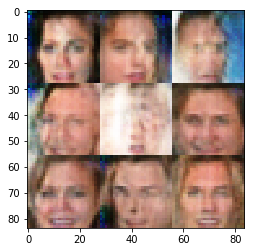

Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.7303


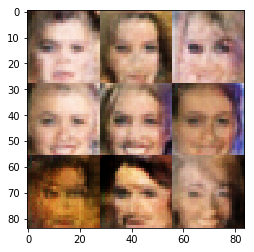

Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.8173


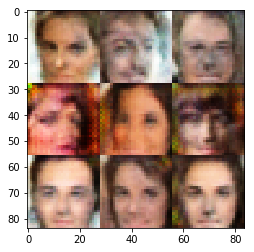

Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.8561


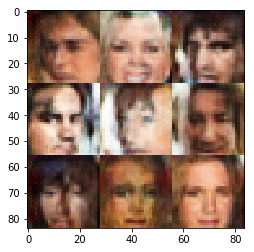

Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.6365


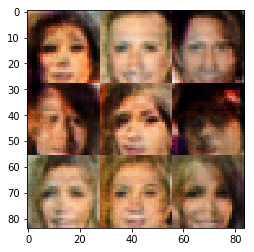

Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.8133


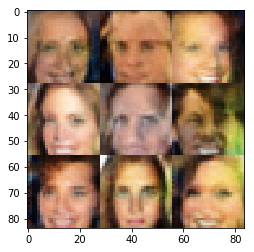

Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.9055
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.7746


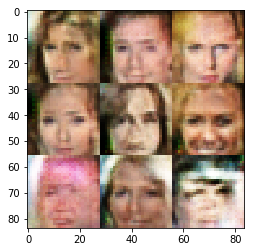

Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.9226
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.7910


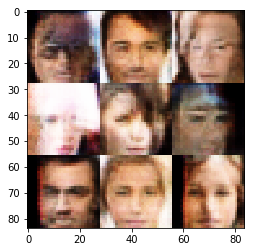

Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.8395


In [46]:
batch_size = 32
z_dim = 64
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

Epoch 1/1... Discriminator Loss: 0.7966... Generator Loss: 1.2732
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.9612
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 1.0081


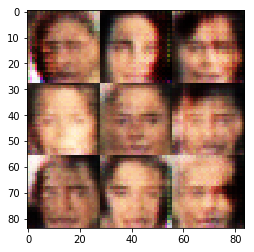

Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.4968
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.5714... Generator Loss: 0.5738


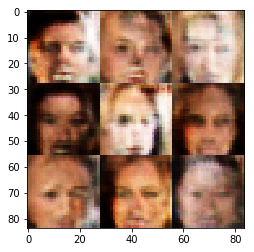

Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.5217... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.7711... Generator Loss: 0.3534


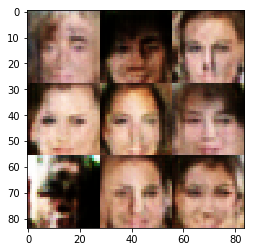

Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.6531... Generator Loss: 0.4662
Epoch 1/1... Discriminator Loss: 1.6601... Generator Loss: 0.5040
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.8697


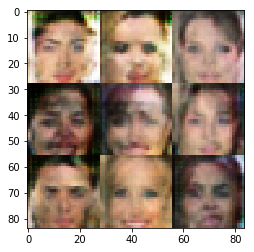

Epoch 1/1... Discriminator Loss: 1.5200... Generator Loss: 0.5447
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 1.6063... Generator Loss: 0.5408
Epoch 1/1... Discriminator Loss: 1.5465... Generator Loss: 0.6058


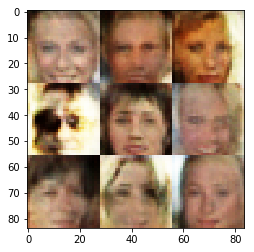

Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.6277... Generator Loss: 0.4908
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.6253


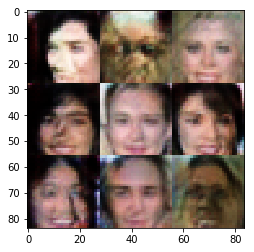

Epoch 1/1... Discriminator Loss: 1.5717... Generator Loss: 0.5326
Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 0.5334
Epoch 1/1... Discriminator Loss: 1.6433... Generator Loss: 0.4755
Epoch 1/1... Discriminator Loss: 1.5708... Generator Loss: 0.5484


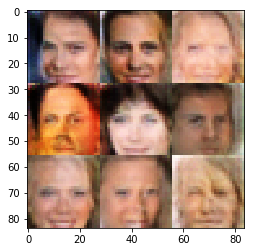

Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6721


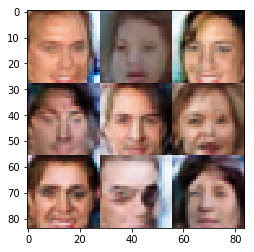

Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.5394... Generator Loss: 0.5293
Epoch 1/1... Discriminator Loss: 1.5144... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.6753


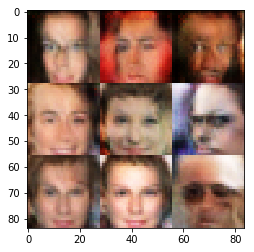

Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.4967... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.6346


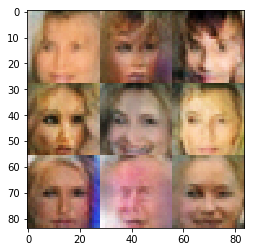

Epoch 1/1... Discriminator Loss: 1.6160... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.5829... Generator Loss: 0.5211
Epoch 1/1... Discriminator Loss: 1.5277... Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7364


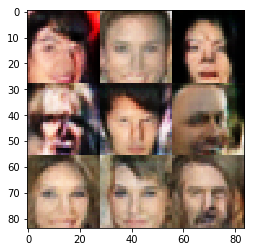

Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.5852


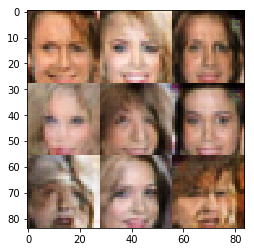

Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.5439... Generator Loss: 0.5666
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.5787... Generator Loss: 0.5624


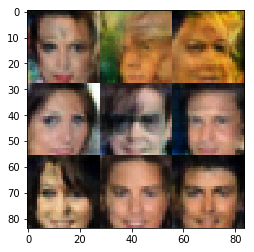

Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.5730... Generator Loss: 0.5383
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.6521


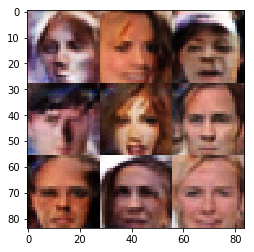

Epoch 1/1... Discriminator Loss: 1.5836... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 1.5666... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.7860


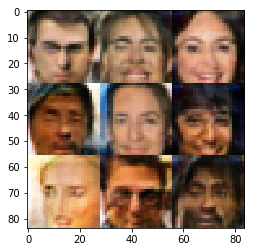

Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.6840


In [47]:
batch_size = 32
z_dim = 256
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.